In [ ]:
import torch
from torch import nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
import tqdm
import torch.optim as optim
import numpy as np
from sklearn.utils import shuffle


data = pd.read_csv("protein_data.tsv.gz", sep="\t")
data = data[data["Length"] <= 256] # removes all proteins with a length > 256
# Reduce EC number to 3 digits to decrease data size
data = data.dropna(subset=['EC number']).assign(
    ec_number_reduced = lambda x: x['EC number'].str.split(".").str[:3].str.join(".")
)

# Filter out EC numbers with frequency less than 100
ec_number_counts = data["ec_number_reduced"].value_counts()
data = data[data["ec_number_reduced"].isin(ec_number_counts[ec_number_counts >= 100].index)]

<ipython-input-1-fb25d75d2359>:12: DtypeWarning: Columns (12,15,16,18,19,21,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("protein_data.tsv.gz", sep="\t")


In [ ]:
vocab = set()
for i in data["Sequence"]:
    for j in i:
        vocab.add(j)
tokens = "".join(sorted(list(vocab)))
vocab_size = len(tokens) + 1
num_classes = len(set(data["ec_number_reduced"].tolist()))

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return tokenize(self.data[idx]), self.labels[idx]

def tokenize(sequence, max_length=256):
    aa_to_idx = {aa : idx + 1 for idx, aa in enumerate(tokens)}
    encoding = np.zeros(max_length, dtype=int)
    for i, aa in enumerate(sequence):
        if aa in aa_to_idx:
            encoding[i] = aa_to_idx[aa]
    return encoding

encoder = OneHotEncoder(sparse=False)
encoded_column = encoder.fit_transform(data[["ec_number_reduced"]])

data, encoded_column = shuffle(data, encoded_column, random_state=42)

# Split data into 80% training data and 20% validation data
train_size = int(0.8 * len(data))
train_data = data[:train_size]
val_data = data[train_size:]

train_labels = encoded_column[:train_size]
val_labels = encoded_column[train_size:]

train_dataset = CustomDataset(train_data["Sequence"].tolist(), train_labels)
val_dataset = CustomDataset(val_data["Sequence"].tolist(), val_labels)

# Used to combine data into batches
def collate_fn(batch):
    proteins = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    return proteins, torch.tensor(labels)

batch_size = 64
# Put data into batches
train_dataloader = DataLoader(train_dataset, batch_size, collate_fn=collate_fn, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size, collate_fn=collate_fn, shuffle=True)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes, vocab_size, embedding_dim=16, num_filters=512, max_kernel_size=129, dense_depth=0):
        super(CNNModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Define convolutional layers with different kernel sizes
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=kernel_size)
            for kernel_size in range(8, max_kernel_size, 8)
        ])

        # Define pooling layers for each convolutional layer
        self.pool_layers = nn.ModuleList([
            nn.MaxPool1d(kernel_size=256 - kernel_size + 1)  # MAXLEN = 256 (adjust as per your data)
            for kernel_size in range(8, max_kernel_size, 8)
        ])

        # Fully connected layers
        self.flatten_layers = nn.ModuleList([
            nn.Flatten()
            for _ in range(len(self.conv_layers))
        ])

        input_dim = len(self.conv_layers) * num_filters
        self.fc_layers = nn.ModuleList([
            nn.Linear(input_dim if i == 0 else 128, 128)
            for i in range(dense_depth)
        ])
        self.output_layer = nn.Linear(128 if dense_depth > 0 else input_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)

        conv_outputs = []
        for conv, pool, flatten in zip(self.conv_layers, self.pool_layers, self.flatten_layers):
            conv_out = nn.functional.relu(conv(x))
            pooled_out = pool(conv_out)
            flattened_out = flatten(pooled_out)
            conv_outputs.append(flattened_out)

        x = torch.cat(conv_outputs, dim=1)

        for fc in self.fc_layers:
            x = F.relu(fc(x))

        x = self.output_layer(x)
        return x

model = CNNModel(num_classes, vocab_size).to("cuda")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
categories = encoder.categories_[0]

ec_to_index = {category : index for index, category in enumerate(categories)}
index_to_ec = {index : category for index, category in enumerate(categories)}

custom_weights = [0 for _ in range(num_classes)]

for ec in data["ec_number_reduced"]:
    index = ec_to_index[ec]
    custom_weights[index] += 1

custom_weights = torch.tensor(custom_weights, dtype=torch.float32)
custom_weights = custom_weights.min() / custom_weights
weight_tensor = custom_weights.to('cuda')

loss_function = nn.CrossEntropyLoss(weight=weight_tensor)

learning_rate = 0.001
epochs = 1000
early_stop_count = 5
min_loss_improvement = 0.001

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []
accuracies = []
top_5_accuracies = []

best_train_loss = float("inf")
no_improvement_count = 0

train_vs_val_loss = []
for epoch in range(0, epochs):
    model.train()

    train_loss = 0
    for batch in tqdm.tqdm(train_dataloader):
        inputs = torch.tensor(batch[0]).to("cuda")
        labels = batch[1].to("cuda")

        optimizer.zero_grad()
        logits = model(inputs)
        loss = loss_function(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)
    losses.append(train_loss)

    # Accuracy
    model.eval()

    correct = 0
    total = 0
    top_5_correct = 0
    top_5_total = 0
    val_loss = 0

    with torch.no_grad():
        for batch in val_dataloader:
            inputs = torch.tensor(batch[0]).to("cuda")
            labels = batch[1].to("cuda")

            # Top-1 Accuracy
            logits = model(inputs)
            probs = nn.functional.softmax(logits, dim=1)

            pred_class = probs.argmax(-1).flatten()
            labels = labels.argmax(-1).flatten()
            correct += (pred_class == labels).sum().item()
            total += pred_class.shape[0]

            # Top-5 Accuracy
            pred_classes = probs.topk(5, dim=1)[1]

            for i in range(pred_classes.shape[0]):
                if labels[i] in pred_classes[i]:
                    top_5_correct += 1
                top_5_total += 1

            val_loss += loss_function(logits, labels).item()
        val_loss /= len(val_dataloader)

    train_vs_val_loss.append((train_loss, val_loss))

    accuracy = correct / total * 100
    top_5_accuracy = top_5_correct / top_5_total * 100
    accuracies.append(accuracy)
    top_5_accuracies.append(accuracy)
    print(f"Epoch {epoch}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, accuracy: {accuracy}")

    # Early stop
    if best_train_loss - train_loss > min_loss_improvement:
        best_train_loss = train_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= early_stop_count:
        break

  6%|▌         | 51/875 [00:07<02:00,  6.84it/s]


KeyboardInterrupt: 

In [ ]:
checkpoint_path = "/content/drive/My Drive/Protein Function ESM/CNN_model_epoch_47.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
model.eval()

correct = 0
total = 0

top_5_correct = 0
top_5_total = 0

class_correct = [0] * num_classes
class_total = [0] * num_classes

class_false_positives = [0] * num_classes
class_false_negatives = [0] * num_classes

with torch.no_grad():
    for batch in tqdm.tqdm(val_dataloader):
        inputs = torch.tensor(batch[0]).to("cuda")
        labels = batch[1].to("cuda")

        # Top-1 Accuracy
        logits = model(inputs)
        probs = nn.functional.softmax(logits, dim=1)

        pred_class = probs.argmax(-1).flatten()
        labels = labels.argmax(-1).flatten()
        correct += (pred_class == labels).sum().item()
        total += pred_class.shape[0]

        # Top-5 Accuracy
        pred_classes = probs.topk(60, dim=1)[1]

        for i in range(pred_classes.shape[0]):
            if labels[i] in pred_classes[i]:
                top_5_correct += 1
            top_5_total += 1

        # Accuracy per class
        for i in range(labels.shape[0]):
            if pred_class[i] == labels[i]:
                class_correct[labels[i]] += 1
            else:
                class_false_positives[pred_class[i]] += 1 # Prediction was wrong
                class_false_negatives[labels[i]] += 1 # Label was not predicted
            class_total[labels[i]] += 1

100%|██████████| 219/219 [00:10<00:00, 20.72it/s]


In [ ]:
accuracy = correct / total * 100
top_5_accuracy = top_5_correct / top_5_total * 100
print(f"Accuracy: {accuracy:.4f}")
print(f"Top-5 Accuracy: {top_5_accuracy:.4f}")

highest = 0
highest_idx = 0
for i in range(num_classes):
    if class_total[i] != 0:
        if class_correct[i] / class_total[i] > highest:
            highest = class_correct[i] / class_total[i]
            highest_idx = i

lowest = float("inf")
lowest_idx = 0
for i in range(num_classes):
    if class_total[i] != 0:
        if class_correct[i] / class_total[i] < lowest:
            lowest = class_correct[i] / class_total[i]
            lowest_idx = i

highest_accuracy = highest * 100
lowest_accuracy = lowest * 100
print(f"Highest Accuracy Label: {highest_idx}, Accuracy: {highest_accuracy:.4f}%")
print(f"Lowest Accuracy Label: {lowest_idx}, Accuracy: {lowest_accuracy:.4f}%")

Accuracy: 96.0354
Top-5 Accuracy: 99.8000
Highest Accuracy Label: 8, Accuracy: 100.0000%
Lowest Accuracy Label: 47, Accuracy: 45.0000%


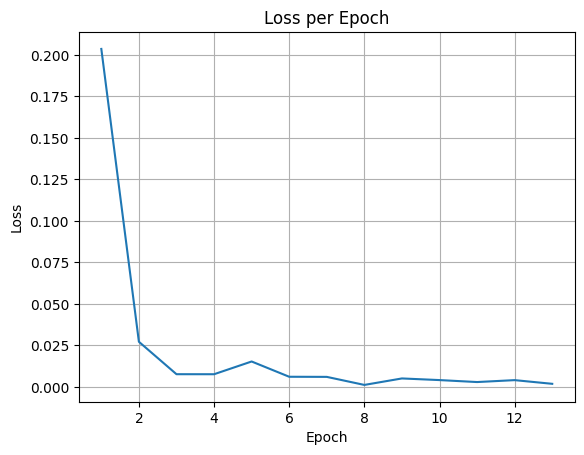

In [ ]:
import matplotlib.pyplot as plt

epochs_lst = list(range(1, len(losses)+1))

plt.plot(epochs_lst, losses)
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

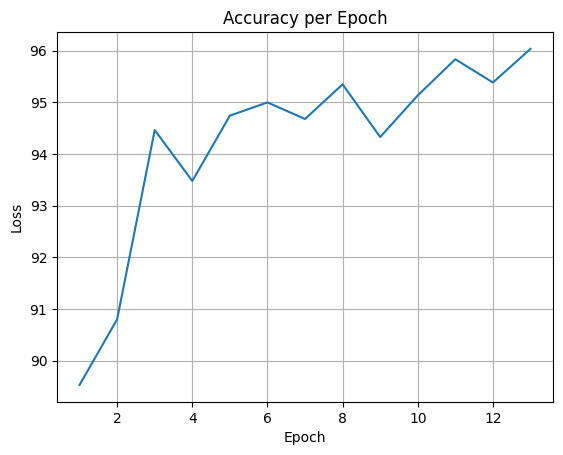

In [ ]:
plt.plot(epochs_lst, accuracies)
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

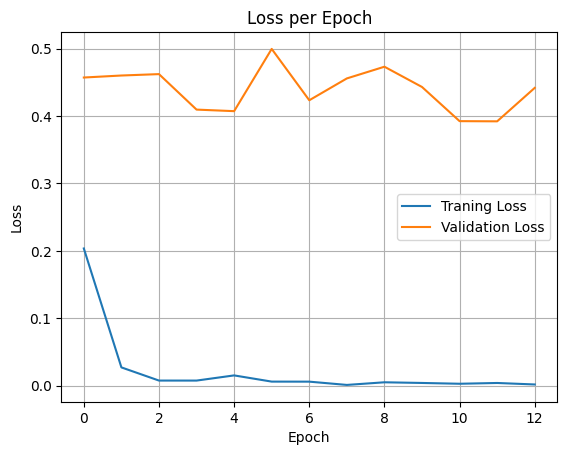

In [ ]:
val_losses = [x[1] for x in train_vs_val_loss]

plt.plot(losses, label="Traning Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

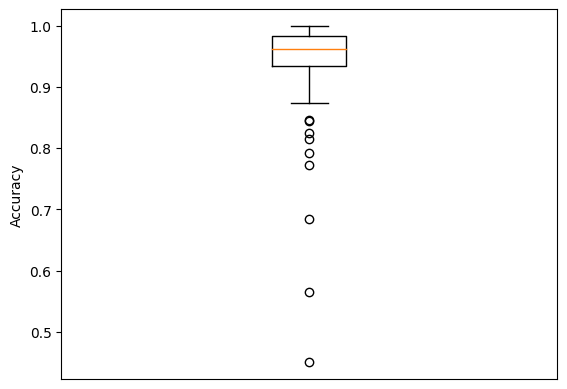

0.9629629629629629
0.9347826086956522 0.9835233441910967 0.04874073549544444
[(0.6842105263157895, 0, '1.-.-'), (0.8441558441558441, 1, '1.1.1'), (0.7916666666666666, 25, '2.7.11'), (0.5652173913043478, 40, '3.1.4'), (0.8461538461538461, 41, '3.2.1'), (0.8148148148148148, 43, '3.4.-'), (0.45, 47, '3.4.24'), (0.825, 57, '4.1.3'), (0.7727272727272727, 67, '5.3.3')]


In [ ]:
import matplotlib.pyplot as plt

class_accuracies = []
for i in range(num_classes):
    if class_total[i] > 0:
        accuracy = class_correct[i] / class_total[i]
        class_accuracies.append((accuracy, i))

#class_accuracies.sort()

accuracies_only = [acc[0] for acc in class_accuracies]
plt.boxplot(accuracies_only)
plt.xticks([])
plt.ylabel("Accuracy")
plt.show()

Q1 = np.percentile(accuracies_only, 25)
median = np.percentile(accuracies_only, 50)
Q3 = np.percentile(accuracies_only, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = [(acc[0], acc[1], index_to_ec[acc[1]]) for acc in class_accuracies if acc[0] < lower_bound or acc[0] > upper_bound]

print(median)
print(Q1, Q3, IQR)
print(outliers)

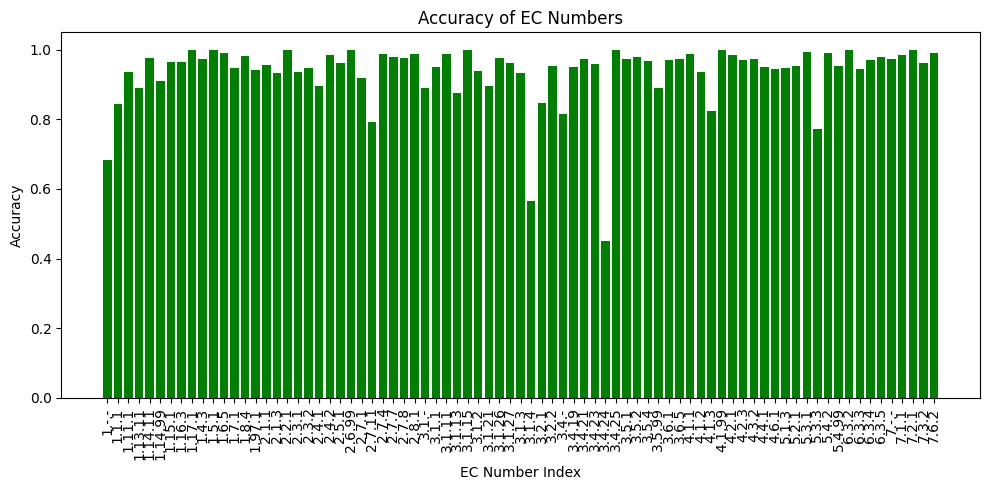

In [ ]:
accuracies = [(i, class_correct[i] / class_total[i]) for i in range(num_classes) if class_total[i] > 0]
ec = [index_to_ec[acc[0]] for acc in accuracies]
lst = [acc[1] for acc in accuracies]

plt.figure(figsize=(10, 5))
plt.bar(range(len(lst)), lst, color='green')
plt.title("Accuracy of EC Numbers")
plt.xlabel("EC Number Index")
plt.ylabel("Accuracy")
plt.xticks(range(len(ec)), ec, rotation='vertical')
plt.tight_layout()
plt.show()

In [ ]:
checkpoint = {
            "epoch": epoch + 1,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "loss": loss.item()
        }

torch.save(checkpoint, f"/content/drive/My Drive/Protein Function ESM/CNN_model_epoch_47.pth")

In [ ]:
from collections import defaultdict
import tqdm

# Initialize counters
correct = 0
total = 0
top_5_correct = 0
top_5_total = 0

class_correct = defaultdict(int)
class_false_positives = defaultdict(int)
class_false_negatives = defaultdict(int)
class_total = defaultdict(int)

with torch.no_grad():
    for batch in tqdm.tqdm(val_dataloader):
        inputs = torch.tensor(batch[0]).to("cuda")
        labels = batch[1].to("cuda")

        # Top-1 Accuracy
        logits = model(inputs)
        probs = nn.functional.softmax(logits, dim=1)

        pred_class = probs.argmax(-1).flatten()
        labels = labels.argmax(-1).flatten()
        correct += (pred_class == labels).sum().item()
        total += pred_class.shape[0]

        # Top-5 Accuracy
        pred_classes = probs.topk(5, dim=1)[1]

        for i in range(pred_classes.shape[0]):
            if labels[i] in pred_classes[i]:
                top_5_correct += 1
            top_5_total += 1

        # Accuracy per class
        for i in range(labels.shape[0]):
            if pred_class[i] == labels[i]:
                class_correct[labels[i].item()] += 1
            else:
                class_false_positives[pred_class[i].item()] += 1 # Prediction was wrong
                class_false_negatives[labels[i].item()] += 1 # Label was not predicted
            class_total[labels[i].item()] += 1

# Calculate precision, recall, and F1-score for each class
class_precision = {}
class_recall = {}
class_f1_score = {}
precision_count = 0
recall_count = 0


for cls in class_total.keys():
    tp = class_correct[cls]
    fp = class_false_positives[cls]
    fn = class_false_negatives[cls]

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    class_precision[cls] = precision
    class_recall[cls] = recall
    class_f1_score[cls] = f1_score

    precision_count += precision
    recall_count += recall

# Calculate macro and weighted F1-score
macro_f1 = sum(class_f1_score.values()) / len(class_f1_score)
weighted_f1 = sum(class_f1_score[cls] * class_total[cls] for cls in class_f1_score) / sum(class_total.values())

# Print overall accuracy
print(f'Overall Top-1 Accuracy: {correct / total:.4f}')
print(f'Overall Top-5 Accuracy: {top_5_correct / top_5_total:.4f}')

# Print precision, recall, and F1-score for each class
for cls in class_total.keys():
    print(f'Class {cls}: Precision = {class_precision[cls]:.4f}, Recall = {class_recall[cls]:.4f}, F1-score = {class_f1_score[cls]:.4f}')

# Print macro and weighted F1-scores
print(f'Macro F1-score: {macro_f1:.4f}')
print(f'Weighted F1-score: {weighted_f1:.4f}')
print(precision_count / len(class_total), recall_count / len(class_total))

100%|██████████| 219/219 [00:11<00:00, 19.52it/s]

Overall Top-1 Accuracy: 0.9604
Overall Top-5 Accuracy: 0.9772
Class 45: Precision = 0.9721, Recall = 0.9721, F1-score = 0.9721
Class 68: Precision = 1.0000, Recall = 0.9906, F1-score = 0.9953
Class 21: Precision = 0.9769, Recall = 0.9850, F1-score = 0.9809
Class 75: Precision = 0.9683, Recall = 0.9858, F1-score = 0.9770
Class 2: Precision = 0.8866, Recall = 0.9348, F1-score = 0.9101
Class 24: Precision = 0.9785, Recall = 0.9193, F1-score = 0.9480
Class 18: Precision = 0.9631, Recall = 0.9359, F1-score = 0.9493
Class 15: Precision = 0.9553, Recall = 0.9572, F1-score = 0.9563
Class 32: Precision = 1.0000, Recall = 0.9886, F1-score = 0.9943
Class 62: Precision = 1.0000, Recall = 0.9500, F1-score = 0.9744
Class 27: Precision = 0.9636, Recall = 0.9790, F1-score = 0.9713
Class 9: Precision = 1.0000, Recall = 0.9726, F1-score = 0.9861
Class 59: Precision = 0.9482, Recall = 0.9837, F1-score = 0.9656
Class 26: Precision = 0.9986, Recall = 0.9864, F1-score = 0.9925
Class 37: Precision = 0.9055, 

In [ ]:
for i in class_accuracies:
    print(i[0], index_to_ec[i[1]])

0.6842105263157895 1.-.-
0.8441558441558441 1.1.1
0.9347826086956522 1.11.1
0.8888888888888888 1.13.11
0.9761904761904762 1.14.11
0.9090909090909091 1.14.99
0.9659090909090909 1.15.1
0.9642857142857143 1.16.3
1.0 1.17.1
0.9726027397260274 1.4.3
1.0 1.5.1
0.9902912621359223 1.6.5
0.9473684210526315 1.7.1
0.9833333333333333 1.8.4
0.9428571428571428 1.97.1
0.9572139303482587 2.1.1
0.9318181818181818 2.1.3
1.0 2.2.1
0.9358974358974359 2.3.1
0.9476190476190476 2.3.2
0.8947368421052632 2.4.1
0.985 2.4.2
0.9610027855153204 2.5.1
1.0 2.6.99
0.9193083573487032 2.7.1
0.7916666666666666 2.7.11
0.986449864498645 2.7.4
0.9790382244143033 2.7.7
0.9751552795031055 2.7.8
0.989010989010989 2.8.1
0.8907103825136612 3.1.-
0.9507829977628636 3.1.1
0.9886363636363636 3.1.11
0.875 3.1.13
1.0 3.1.15
0.9397590361445783 3.1.2
0.8971428571428571 3.1.21
0.9776119402985075 3.1.26
0.9629629629629629 3.1.27
0.9322033898305084 3.1.3
0.5652173913043478 3.1.4
0.8461538461538461 3.2.1
0.9540229885057471 3.2.2
0.8148148